In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/Users/jainivedhitha/Desktop/fake reviews dataset.csv")

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [4]:
import nltk
nltk.download('punkt', download_dir='/Users/jainivedhitha/nltk_data')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


False

In [5]:
print(nltk.data.path)

['/Users/jainivedhitha/nltk_data', '/Library/Frameworks/Python.framework/Versions/3.11/nltk_data', '/Library/Frameworks/Python.framework/Versions/3.11/share/nltk_data', '/Library/Frameworks/Python.framework/Versions/3.11/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


In [6]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jainivedhitha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jainivedhitha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jainivedhitha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
lemmatizer = WordNetLemmatizer()

In [8]:
stemmer = PorterStemmer()

In [9]:
stop_words = set(stopwords.words('english'))

In [10]:
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]  # Remove non-alphabetic tokens
    tokens = [word.lower() for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    tokens = [stemmer.stem(word) for word in tokens]  # Stemming
    return ' '.join(tokens)

In [11]:
df['cleaned_text'] = df['text_'].apply(preprocess_text)

In [12]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(df['text_']).toarray()


In [13]:
X_normalized = normalize(X)

    ELBOW METHOD TO FIND THE OPTIMAL CLUSTERS

In [14]:
inertia = []
k_range = range(1, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_normalized)
    inertia.append(kmeans.inertia_)

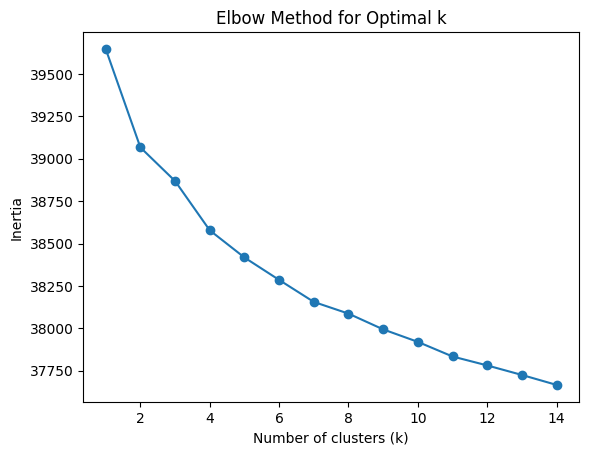

In [15]:
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [16]:
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_final.fit(X_normalized)
df['cluster'] = kmeans_final.labels_


In [17]:
silhouette_avg = silhouette_score(X_normalized, df['cluster'])
print(f"Silhouette Score for K-Means: {silhouette_avg}")

Silhouette Score for K-Means: 0.009637291078292566


    DBSCAN CLUSTERING

In [18]:
from sklearn.cluster import DBSCAN

In [19]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [20]:
nearest_neighbors = NearestNeighbors(n_neighbors=3).fit(X_normalized)
distances, indices = nearest_neighbors.kneighbors(X_normalized)
distances = np.sort(distances[:, -1]) 

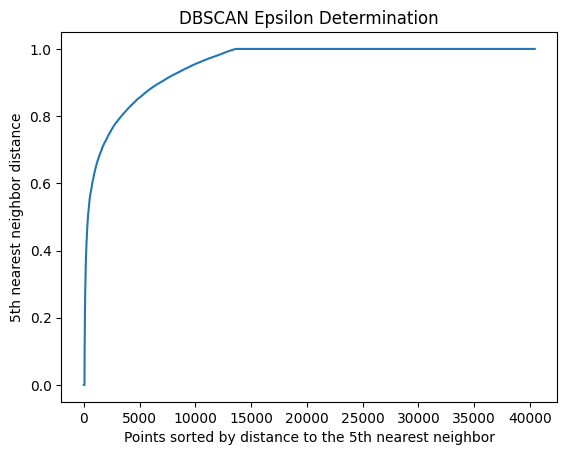

In [21]:
plt.plot(distances)
plt.xlabel("Points sorted by distance to the 5th nearest neighbor")
plt.ylabel("5th nearest neighbor distance")
plt.title("DBSCAN Epsilon Determination")
plt.show()

In [22]:
epsilon = 0.6  # Update based on the k-distance graph
min_samples = 5

In [23]:
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_normalized)
df['cluster'] = dbscan_labels

In [24]:
filtered_df = df[df['cluster'] != -1]
filtered_X = X[dbscan_labels != -1]
filtered_labels = dbscan_labels[dbscan_labels != -1]

In [25]:
if len(set(filtered_labels)) > 1:
    silhouette_avg = silhouette_score(filtered_X, filtered_labels)
    print(f"Silhouette Score for DBSCAN: {silhouette_avg}")
else:
    print("Silhouette Score cannot be computed as there is only one cluster or all points are noise.")


Silhouette Score for DBSCAN: 0.3739507987826782


In [26]:
lda_model = LatentDirichletAllocation(n_components=len(set(filtered_labels)), random_state=42)
lda_model.fit(filtered_X)

LatentDirichletAllocation(n_components=48, random_state=42)

In [27]:
print("\nTopics from LDA on DBSCAN Clusters:")
for idx, topic in enumerate(lda_model.components_):
    print(f"Topic {idx}: ", [tfidf.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Topics from LDA on DBSCAN Clusters:
Topic 0:  ['received', 'watch', 'im', 'higher', 'unbiased', 'purposes', 'channel', 'promised', 'youtube', 'thorough']
Topic 1:  ['friend', 'used', 'dog', 'able', 'fixed', 'plug', 'remove', 'sensitive', 'ear', 'ears']
Topic 2:  ['felt', 'fell', 'feet', 'feels', 'feelings', 'feeling', 'feel', 'feeding', 'fellow', 'zoom']
Topic 3:  ['reason', 'children', 'broken', 'useful', 'handy', 'bought', 'awesome', 'kid', 'throwing', 'turner']
Topic 4:  ['fits', 'use', '36d', 'clothes', '32d', 'buying', 'loves', 'bought', 'daughter', 'baby']
Topic 5:  ['feeding', 'feeder', 'feedback', 'feet', 'fit', 'bad', 'reviews', 'surprised', 'likes', 'plastic']
Topic 6:  ['feels', 'feelings', 'feeling', 'feel', 'feeding', 'feeder', 'fell', 'zoom', 'lot', 'said']
Topic 7:  ['feel', 'feeding', 'feeder', 'feels', 'fi', 'imagination', 'game', 'jack', 'wrap', 'labeled']
Topic 8:  ['sharpen', 'anybody', 'handle', 'sharp', 'tough', 'cold', 'heat', 'sheath', 'arm', 'personalities']
T

        CLASSIFICATION TASKS

In [28]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [29]:
X_class = tfidf.fit_transform(df['cleaned_text']).toarray()
y_class = df['label'] 

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42)

    LOGISTIC REGRESSION

In [31]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

    SUPPORT VECTOR MACHINE

In [32]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)


    MACHINE LEARNING MODEL EVALUATION

In [33]:
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_log_reg))
print("SVM Report:\n", classification_report(y_test, y_pred_svm))

Logistic Regression Report:
               precision    recall  f1-score   support

          CG       0.86      0.83      0.84      6066
          OR       0.84      0.86      0.85      6064

    accuracy                           0.85     12130
   macro avg       0.85      0.85      0.85     12130
weighted avg       0.85      0.85      0.85     12130

SVM Report:
               precision    recall  f1-score   support

          CG       0.88      0.85      0.87      6066
          OR       0.85      0.89      0.87      6064

    accuracy                           0.87     12130
   macro avg       0.87      0.87      0.87     12130
weighted avg       0.87      0.87      0.87     12130



    LSTM

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [35]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_text'])
X_seq = tokenizer.texts_to_sequences(df['cleaned_text'])
X_padded = pad_sequences(X_seq, maxlen=200)

In [36]:
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_padded, y_class, test_size=0.3, random_state=42)


In [39]:
from sklearn.preprocessing import LabelEncoder

In [40]:
le = LabelEncoder()

In [41]:
y_train_dl = le.fit_transform(y_train_dl)
y_test_dl = le.fit_transform(y_test_dl)

In [42]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [43]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
model.fit(X_train_dl, y_train_dl, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
354/354 ━━━━━━━━━━━━━━━━━━━━ 56s 155ms/step - accuracy: 0.7463 - loss: 0.4629 - val_accuracy: 0.9039 - val_loss: 0.2343
Epoch 2/5
354/354 ━━━━━━━━━━━━━━━━━━━━ 62s 174ms/step - accuracy: 0.9226 - loss: 0.1925 - val_accuracy: 0.9113 - val_loss: 0.2162
Epoch 3/5
354/354 ━━━━━━━━━━━━━━━━━━━━ 65s 183ms/step - accuracy: 0.9435 - loss: 0.1418 - val_accuracy: 0.9152 - val_loss: 0.2133
Epoch 4/5
354/354 ━━━━━━━━━━━━━━━━━━━━ 62s 175ms/step - accuracy: 0.9575 - loss: 0.1132 - val_accuracy: 0.9143 - val_loss: 0.2420
Epoch 5/5
354/354 ━━━━━━━━━━━━━━━━━━━━ 63s 177ms/step - accuracy: 0.9684 - loss: 0.0839 - val_accuracy: 0.9099 - val_loss: 0.2453


In [45]:
model.evaluate(X_test_dl, y_test_dl)

380/380 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9057 - loss: 0.2622


[0.26551195979118347, 0.904121994972229]

    ROBERTA

In [64]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification, RobertaConfig
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

In [65]:
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
model_roberta = TFRobertaForSequenceClassification.from_pretrained('roberta-base')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [66]:
train_encodings = tokenizer_roberta(list(df['cleaned_text']), truncation=True, padding=True, max_length=200, return_tensors="tf")

In [67]:
X_train_roberta, X_test_roberta, y_train_roberta, y_test_roberta = train_test_split(
    np.array(train_encodings['input_ids']),
    y_class,
    test_size=0.3,
    random_state=42
)

In [68]:
y_train_roberta

25099    OR
28738    OR
37154    CG
12309    OR
16629    OR
         ..
6265     CG
11284    OR
38158    OR
860      OR
15795    CG
Name: label, Length: 28302, dtype: object

In [69]:
le = LabelEncoder()
y_train_roberta = le.fit_transform(y_train_roberta)
y_test_roberta = le.fit_transform(y_test_roberta)

ADDING ATTENTION MASKS FOR BETTER PERFORMANCE OF THE MODEL

In [70]:
attention_masks_train = np.array(train_encodings['attention_mask'])[:len(X_train_roberta)]
attention_masks_test = np.array(train_encodings['attention_mask'])[len(X_train_roberta):]

FINE TUNING CONFIGURATION WITH REGULARIZATION

In [71]:
config = RobertaConfig.from_pretrained('roberta-base', 
                                       num_labels=2,  # Adjust according to your task
                                       hidden_dropout_prob=0.3,  # Dropout regularization
                                       attention_probs_dropout_prob=0.3)

In [72]:
model_roberta = TFRobertaForSequenceClassification.from_pretrained('roberta-base', config=config)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [73]:
for layer in model_roberta.roberta.encoder.layer[:-2]:
    layer.trainable = False

In [74]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

In [76]:
from transformers import create_optimizer

num_train_steps = len(X_train_roberta) // 8 * 3  
optimizer, _ = create_optimizer(
    init_lr=3e-5, 
    num_warmup_steps=0, 
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01
)

# Compile the RoBERTa model with the compatible optimizer
model_roberta.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [77]:
model_roberta.fit(X_train_roberta, y_train_roberta, epochs=3, batch_size=8)

Epoch 1/3
3538/3538 [==============================] - 9635s 3s/step - loss: 0.5395 - accuracy: 0.7017
Epoch 2/3
3538/3538 [==============================] - 8806s 2s/step - loss: 0.3944 - accuracy: 0.8108
Epoch 3/3
3538/3538 [==============================] - 8059s 2s/step - loss: 0.3537 - accuracy: 0.8344


In [78]:
model_roberta.evaluate(X_test_roberta, y_test_roberta)

380/380 [==============================] - 7660s 20s/step - loss: 0.8526 - accuracy: 0.7437


[0.8525989651679993, 0.7436933517456055]

In [79]:
import matplotlib.pyplot as plt

In [80]:
import numpy as np

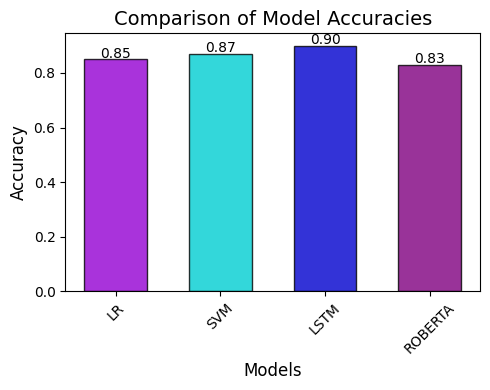

In [86]:
models = ['LR','SVM','LSTM','ROBERTA']
accuracies = [0.85, 0.87, 0.90, 0.83]
colors = ['darkviolet','darkturquoise','mediumblue','purple']

plt.figure(figsize=(5, 4))
bar_positions = np.arange(len(models))
bar_width = 0.6

plt.bar(bar_positions, accuracies, width=bar_width, color= colors, edgecolor='black', alpha=0.8)

plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of Model Accuracies', fontsize=14)
plt.xticks(bar_positions, models, rotation=45, fontsize=10)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()